# Прогнозирование цен потребительского ритейла по тестовой выборке на основе глубоких нейронных сетей
__Выполнил:__ *Домченко Максим*

__Студент группы:__ *РИМ-130962*

In [18]:
# Подключение Google Drive к Colab
from pathlib import Path
from google.colab import drive

drive.mount('/content/drive')
ROOT = Path('/content/drive/MyDrive')

# Настройка структуры папок проекта
PROJECT_DIR = ROOT / 'price_forecasting'
DATA = PROJECT_DIR / 'data'
RAW = DATA / 'raw'
PROCESSED = DATA / 'processed'

print('Проектная папка подключена:', PROJECT_DIR)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Проектная папка подключена: /content/drive/MyDrive/price_forecasting


In [19]:
# Импорт библиотек для обработки и анализа данных
import numpy as np
import pandas as pd

# Библиотеки для визуализации данных
import matplotlib.pyplot as plt
import seaborn as sns

# Настройки отображения pandas и matplotlib
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)
plt.style.use('ggplot')

# Проверка версий библиотек
print("Версия Pandas:", pd.__version__)
print("Версия NumPy:", np.__version__)

Версия Pandas: 2.2.2
Версия NumPy: 2.0.2


In [20]:
# Загрузка исходных данных
calendar_df = pd.read_parquet(PROCESSED / 'calendar_processed.parquet')
sell_prices_df = pd.read_parquet(PROCESSED / 'sell_prices_processed.parquet')

# Генерация базовых календарных признаков
calendar_df['day_of_week'] = calendar_df['date'].dt.weekday
calendar_df['is_weekend'] = calendar_df['day_of_week'].isin([5, 6]).astype(int)
calendar_df['month'] = calendar_df['date'].dt.month
calendar_df['quarter'] = calendar_df['date'].dt.quarter

# Сортировка sell_prices_df для корректного расчёта накопительных признаков
sell_prices_df.sort_values(['store_id', 'item_id', 'wm_yr_wk'], inplace=True)

# Расчёт средней цены каждого товара с накоплением (только прошлые данные)
sell_prices_df['avg_sell_price'] = (
    sell_prices_df
    .groupby(['store_id', 'item_id'], observed=True)['sell_price']
    .expanding()
    .mean()
    .shift(1)
    .reset_index(level=[0, 1], drop=True)
)

# Признак отклонения текущей цены от средней (с учетом только прошлой информации)
sell_prices_df['price_diff_avg'] = sell_prices_df['sell_price'] - sell_prices_df['avg_sell_price']

# Объединение sell_prices с календарём по столбцу wm_yr_wk
final_df = sell_prices_df.merge(calendar_df, on='wm_yr_wk', how='left')

# Проверка итогового датасета после всех исправлений
print('Итоговый датасет после корректной генерации признаков:', final_df.shape)
display(final_df.head(15))

Итоговый датасет после корректной генерации признаков: (47735397, 22)


,store_id,item_id,wm_yr_wk,sell_price,avg_sell_price,price_diff_avg,date,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,day_of_week,is_weekend,quarter
0,CA_1,FOODS_1_001,11101,2.00,NaN,NaN,2011-01-29,Saturday,1,1,2011,d_1,NoEvent,NoEvent,NoEvent,NoEvent,0,0,0,5,1,1
1,CA_1,FOODS_1_001,11101,2.00,NaN,NaN,2011-01-30,Sunday,2,1,2011,d_2,NoEvent,NoEvent,NoEvent,NoEvent,0,0,0,6,1,1
2,CA_1,FOODS_1_001,11101,2.00,NaN,NaN,2011-01-31,Monday,3,1,2011,d_3,NoEvent,NoEvent,NoEvent,NoEvent,0,0,0,0,0,1
3,CA_1,FOODS_1_001,11101,2.00,NaN,NaN,2011-02-01,Tuesday,4,2,2011,d_4,NoEvent,NoEvent,NoEvent,NoEvent,1,1,0,1,0,1
4,CA_1,FOODS_1_001,11101,2.00,NaN,NaN,2011-02-02,Wednesday,5,2,2011,d_5,NoEvent,NoEvent,NoEvent,NoEvent,1,0,1,2,0,1
5,CA_1,FOODS_1_001,11101,2.00,NaN,NaN,2011-02-03,Thursday,6,2,2011,d_6,NoEvent,NoEvent,NoEvent,NoEvent,1,1,1,3,0,1
6,CA_1,FOODS_1_001,11101,2.00,NaN,NaN,2011-02-04,Friday,7,2,2011,d_7,NoEvent,NoEvent,NoEvent,NoEvent,1,0,0,4,0,1
7,CA_1,FOODS_1_001,11102,2.00,2.00,0.00,2011-02-05,Saturday,1,2,2011,d_8,NoEvent,NoEvent,NoEvent,NoEvent,1,1,1,5,1,1
8,CA_1,FOODS_1_001,11102,2.00,2.00,0.00,2011-02-06,Sunday,2,2,2011,d_9,SuperBowl,Sporting,NoEvent,NoEvent,1,1,1,6,1,1
9,CA_1,FOODS_1_001,11102,2.00,2.00,0.00,2011-02-07,Monday,3,2,2011,d_10,NoEvent,NoEvent,NoEvent,NoEvent,1,1,0,0,0,1


In [21]:
# Удаление ненужных (дублирующих) признаков
final_df.drop(['weekday', 'wday'], axis=1, inplace=True)

# Проверка обновлённого набора признаков
print("Обновлённый набор признаков:", final_df.columns.tolist())

Обновлённый набор признаков: ['store_id', 'item_id', 'wm_yr_wk', 'sell_price', 'avg_sell_price', 'price_diff_avg', 'date', 'month', 'year', 'd', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI', 'day_of_week', 'is_weekend', 'quarter']


In [22]:
# Удаление ненужного признака 'd'
final_df.drop(['d'], axis=1, inplace=True)

# Генерация логарифмированной цены (для стабилизации дисперсии)
final_df['log_sell_price'] = np.log1p(final_df['sell_price'])

# Проверка обновлённого датасета
print("Обновлённые признаки:", final_df.columns.tolist())

Обновлённые признаки: ['store_id', 'item_id', 'wm_yr_wk', 'sell_price', 'avg_sell_price', 'price_diff_avg', 'date', 'month', 'year', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI', 'day_of_week', 'is_weekend', 'quarter', 'log_sell_price']


In [23]:
display(final_df.head())

,store_id,item_id,wm_yr_wk,sell_price,avg_sell_price,price_diff_avg,date,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,day_of_week,is_weekend,quarter,log_sell_price
0,CA_1,FOODS_1_001,11101,2.00,NaN,NaN,2011-01-29,1,2011,NoEvent,NoEvent,NoEvent,NoEvent,0,0,0,5,1,1,1.10
1,CA_1,FOODS_1_001,11101,2.00,NaN,NaN,2011-01-30,1,2011,NoEvent,NoEvent,NoEvent,NoEvent,0,0,0,6,1,1,1.10
2,CA_1,FOODS_1_001,11101,2.00,NaN,NaN,2011-01-31,1,2011,NoEvent,NoEvent,NoEvent,NoEvent,0,0,0,0,0,1,1.10
3,CA_1,FOODS_1_001,11101,2.00,NaN,NaN,2011-02-01,2,2011,NoEvent,NoEvent,NoEvent,NoEvent,1,1,0,1,0,1,1.10
4,CA_1,FOODS_1_001,11101,2.00,NaN,NaN,2011-02-02,2,2011,NoEvent,NoEvent,NoEvent,NoEvent,1,0,1,2,0,1,1.10


In [24]:
# Проверка временного периода данных
print("Дата начала данных:", final_df['date'].min())
print("Дата окончания данных:", final_df['date'].max())

# Определение границ выборок
date_min = final_df['date'].min()
date_max = final_df['date'].max()

train_end = date_min + (date_max - date_min) * 0.8
val_end = date_min + (date_max - date_min) * 0.9

# Разделение на выборки по датам (обновлённый датасет)
train_df = final_df[final_df['date'] <= train_end]
val_df = final_df[(final_df['date'] > train_end) & (final_df['date'] <= val_end)]
test_df = final_df[final_df['date'] > val_end]

# Проверка разделения
print(f'Размер тренировочной выборки: {train_df.shape}')
print(f'Размер валидационной выборки: {val_df.shape}')
print(f'Размер тестовой выборки: {test_df.shape}')

Дата начала данных: 2011-01-29 00:00:00
Дата окончания данных: 2016-06-19 00:00:00
Размер тренировочной выборки: (35743638, 20)
Размер валидационной выборки: (5986318, 20)
Размер тестовой выборки: (6005441, 20)


## Выводы по разделению датасета на выборки:

Датасет успешно разделён на три выборки с учётом временной структуры:

- **Тренировочная выборка**: период с 2011-01-29 по ~2015-04. Размер выборки — 35,743,638 записей.
- **Валидационная выборка**: период с ~2015-04 по ~2015-10. Размер выборки — 5,986,318 записей.
- **Тестовая выборка**: период с ~2015-10 по 2016-06-19. Размер выборки — 6,005,441 запись.

Такое разделение позволяет строго соблюдать временную последовательность и избежать утечки данных, обеспечивая корректность последующего моделирования и оценки.

In [25]:
# Сортировка данных по дате
final_df.sort_values(['store_id', 'item_id', 'date'], inplace=True)

# Функция генерации временных признаков с правильным учетом предыдущих наблюдений
def create_time_features(df, base_df=None):
    df = df.copy()

    if base_df is not None:
        combined_df = pd.concat([base_df, df], sort=False)
    else:
        combined_df = df

    combined_df.sort_values(['store_id', 'item_id', 'date'], inplace=True)

    for lag in [1, 7]:
        df[f'price_lag_{lag}'] = combined_df.groupby(['store_id', 'item_id'], observed=True)['sell_price'].shift(lag).loc[df.index]
        df[f'log_price_lag_{lag}'] = combined_df.groupby(['store_id', 'item_id'], observed=True)['log_sell_price'].shift(lag).loc[df.index]

    # Скользящие средние
    df['price_roll_mean_7'] = combined_df.groupby(['store_id', 'item_id'], observed=True)['sell_price'].shift(1).rolling(window=7).mean().loc[df.index]
    df['price_roll_mean_30'] = combined_df.groupby(['store_id', 'item_id'], observed=True)['sell_price'].shift(1).rolling(window=30).mean().loc[df.index]

    # Скользящие средние логарифмированных цен
    df['log_price_roll_mean_7'] = combined_df.groupby(['store_id', 'item_id'], observed=True)['log_sell_price'].shift(1).rolling(window=7).mean().loc[df.index]
    df['log_price_roll_mean_30'] = combined_df.groupby(['store_id', 'item_id'], observed=True)['log_sell_price'].shift(1).rolling(window=30).mean().loc[df.index]

    return df

# Корректная генерация признаков по выборкам:
train_df = create_time_features(train_df)
val_df = create_time_features(val_df, train_df)
test_df = create_time_features(test_df, pd.concat([train_df, val_df], sort=False))

# Проверка созданных признаков на тренировочной выборке
display(train_df.head(15))

,store_id,item_id,wm_yr_wk,sell_price,avg_sell_price,price_diff_avg,date,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,day_of_week,is_weekend,quarter,log_sell_price,price_lag_1,log_price_lag_1,price_lag_7,log_price_lag_7,price_roll_mean_7,price_roll_mean_30,log_price_roll_mean_7,log_price_roll_mean_30
0,CA_1,FOODS_1_001,11101,2.00,NaN,NaN,2011-01-29,1,2011,NoEvent,NoEvent,NoEvent,NoEvent,0,0,0,5,1,1,1.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CA_1,FOODS_1_001,11101,2.00,NaN,NaN,2011-01-30,1,2011,NoEvent,NoEvent,NoEvent,NoEvent,0,0,0,6,1,1,1.10,2.00,1.10,NaN,NaN,NaN,NaN,NaN,NaN
2,CA_1,FOODS_1_001,11101,2.00,NaN,NaN,2011-01-31,1,2011,NoEvent,NoEvent,NoEvent,NoEvent,0,0,0,0,0,1,1.10,2.00,1.10,NaN,NaN,NaN,NaN,NaN,NaN
3,CA_1,FOODS_1_001,11101,2.00,NaN,NaN,2011-02-01,2,2011,NoEvent,NoEvent,NoEvent,NoEvent,1,1,0,1,0,1,1.10,2.00,1.10,NaN,NaN,NaN,NaN,NaN,NaN
4,CA_1,FOODS_1_001,11101,2.00,NaN,NaN,2011-02-02,2,2011,NoEvent,NoEvent,NoEvent,NoEvent,1,0,1,2,0,1,1.10,2.00,1.10,NaN,NaN,NaN,NaN,NaN,NaN
5,CA_1,FOODS_1_001,11101,2.00,NaN,NaN,2011-02-03,2,2011,NoEvent,NoEvent,NoEvent,NoEvent,1,1,1,3,0,1,1.10,2.00,1.10,NaN,NaN,NaN,NaN,NaN,NaN
6,CA_1,FOODS_1_001,11101,2.00,NaN,NaN,2011-02-04,2,2011,NoEvent,NoEvent,NoEvent,NoEvent,1,0,0,4,0,1,1.10,2.00,1.10,NaN,NaN,NaN,NaN,NaN,NaN
7,CA_1,FOODS_1_001,11102,2.00,2.00,0.00,2011-02-05,2,2011,NoEvent,NoEvent,NoEvent,NoEvent,1,1,1,5,1,1,1.10,2.00,1.10,2.00,1.10,2.00,NaN,1.10,NaN
8,CA_1,FOODS_1_001,11102,2.00,2.00,0.00,2011-02-06,2,2011,SuperBowl,Sporting,NoEvent,NoEvent,1,1,1,6,1,1,1.10,2.00,1.10,2.00,1.10,2.00,NaN,1.10,NaN
9,CA_1,FOODS_1_001,11102,2.00,2.00,0.00,2011-02-07,2,2011,NoEvent,NoEvent,NoEvent,NoEvent,1,1,0,0,0,1,1.10,2.00,1.10,2.00,1.10,2.00,NaN,1.10,NaN


- Временные признаки (лаги и скользящие средние цены) корректно рассчитаны отдельно для тренировочной, валидационной и тестовой выборок, с учетом только предыдущих наблюдений, что исключает утечку данных.
- Пропуски (NaN) в начальных периодах естественны, так как в эти моменты нет достаточного количества предыдущих данных для расчёта временных признаков. Они могут быть обработаны на следующем этапе.
- Созданные признаки позволят учесть динамику изменения цен и существенно улучшить прогнозную способность моделей.


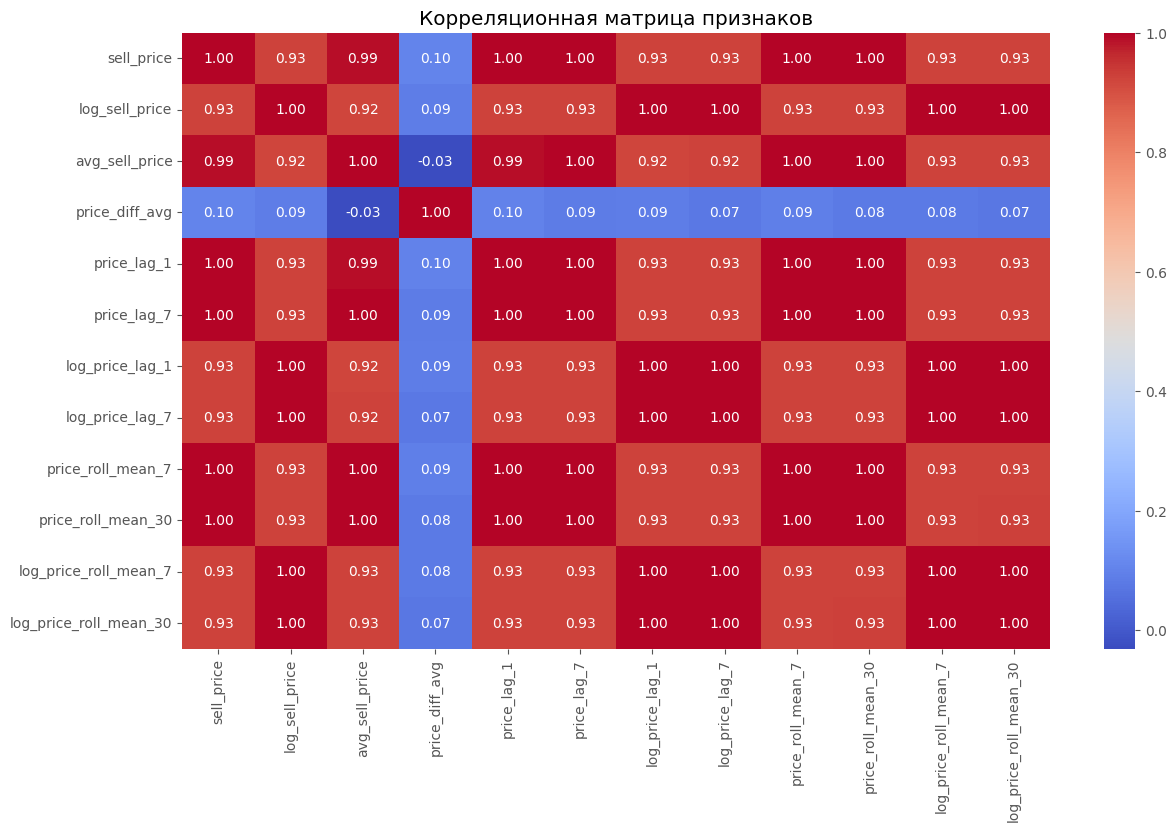

In [26]:
# Проверка корреляций между числовыми признаками на тренировочной выборке
corr_matrix = train_df[['sell_price', 'log_sell_price', 'avg_sell_price', 'price_diff_avg',
                        'price_lag_1', 'price_lag_7', 'log_price_lag_1', 'log_price_lag_7',
                        'price_roll_mean_7', 'price_roll_mean_30',
                        'log_price_roll_mean_7', 'log_price_roll_mean_30']].corr()

# Визуализация корреляций
plt.figure(figsize=(14, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Корреляционная матрица признаков')
plt.show()

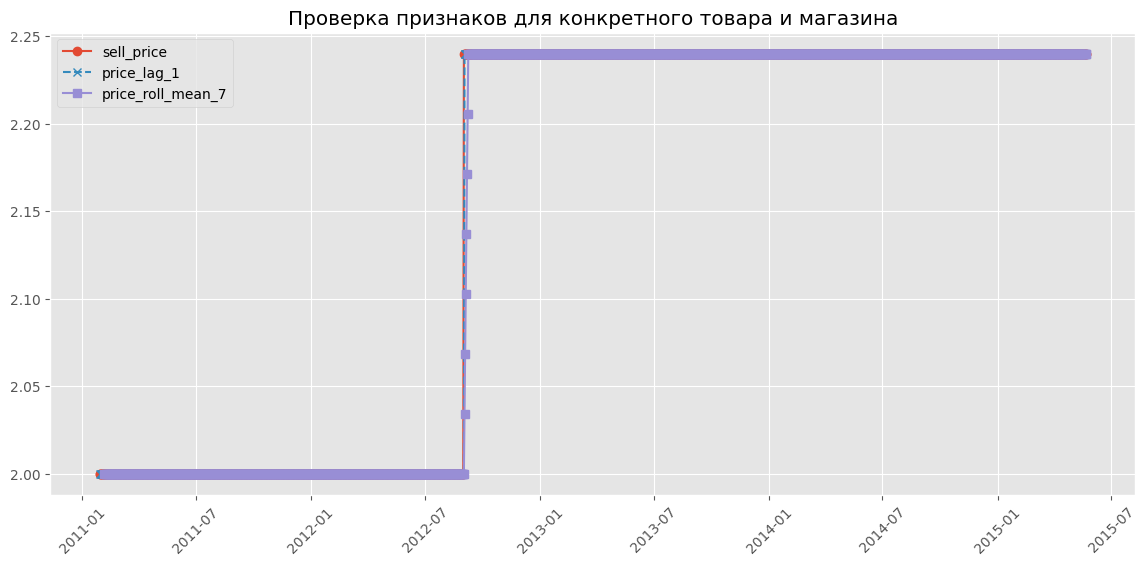

In [27]:
example_item = train_df[(train_df['store_id'] == 'CA_1') & (train_df['item_id'] == 'FOODS_1_001')]

plt.figure(figsize=(14,6))
plt.plot(example_item['date'], example_item['sell_price'], marker='o', label='sell_price')
plt.plot(example_item['date'], example_item['price_lag_1'], marker='x', linestyle='--', label='price_lag_1')
plt.plot(example_item['date'], example_item['price_roll_mean_7'], marker='s', linestyle='-', label='price_roll_mean_7')

plt.xticks(rotation=45)
plt.legend()
plt.title('Проверка признаков для конкретного товара и магазина')
plt.grid(True)
plt.show()


- Цены товаров практически не меняются на протяжении длительного времени (несколько месяцев или даже лет).
- Это объясняет крайне высокую корреляцию между лаговыми и скользящими признаками — их значения оказываются почти полностью идентичными.
- Такая ситуация не является ошибкой кода, а является особенностью исходного датасета.

In [28]:
cols_to_drop = [
    'price_lag_7', 'log_price_lag_7',
    'price_roll_mean_30', 'log_price_roll_mean_30',
    'avg_sell_price', 'price_diff_avg'
]

train_df.drop(columns=cols_to_drop, inplace=True)
val_df.drop(columns=cols_to_drop, inplace=True)
test_df.drop(columns=cols_to_drop, inplace=True)

# Проверим финальный набор признаков
print("Итоговый набор признаков после удаления лишних:")
print(train_df.columns.tolist())

Итоговый набор признаков после удаления лишних:
['store_id', 'item_id', 'wm_yr_wk', 'sell_price', 'date', 'month', 'year', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI', 'day_of_week', 'is_weekend', 'quarter', 'log_sell_price', 'price_lag_1', 'log_price_lag_1', 'price_roll_mean_7', 'log_price_roll_mean_7']


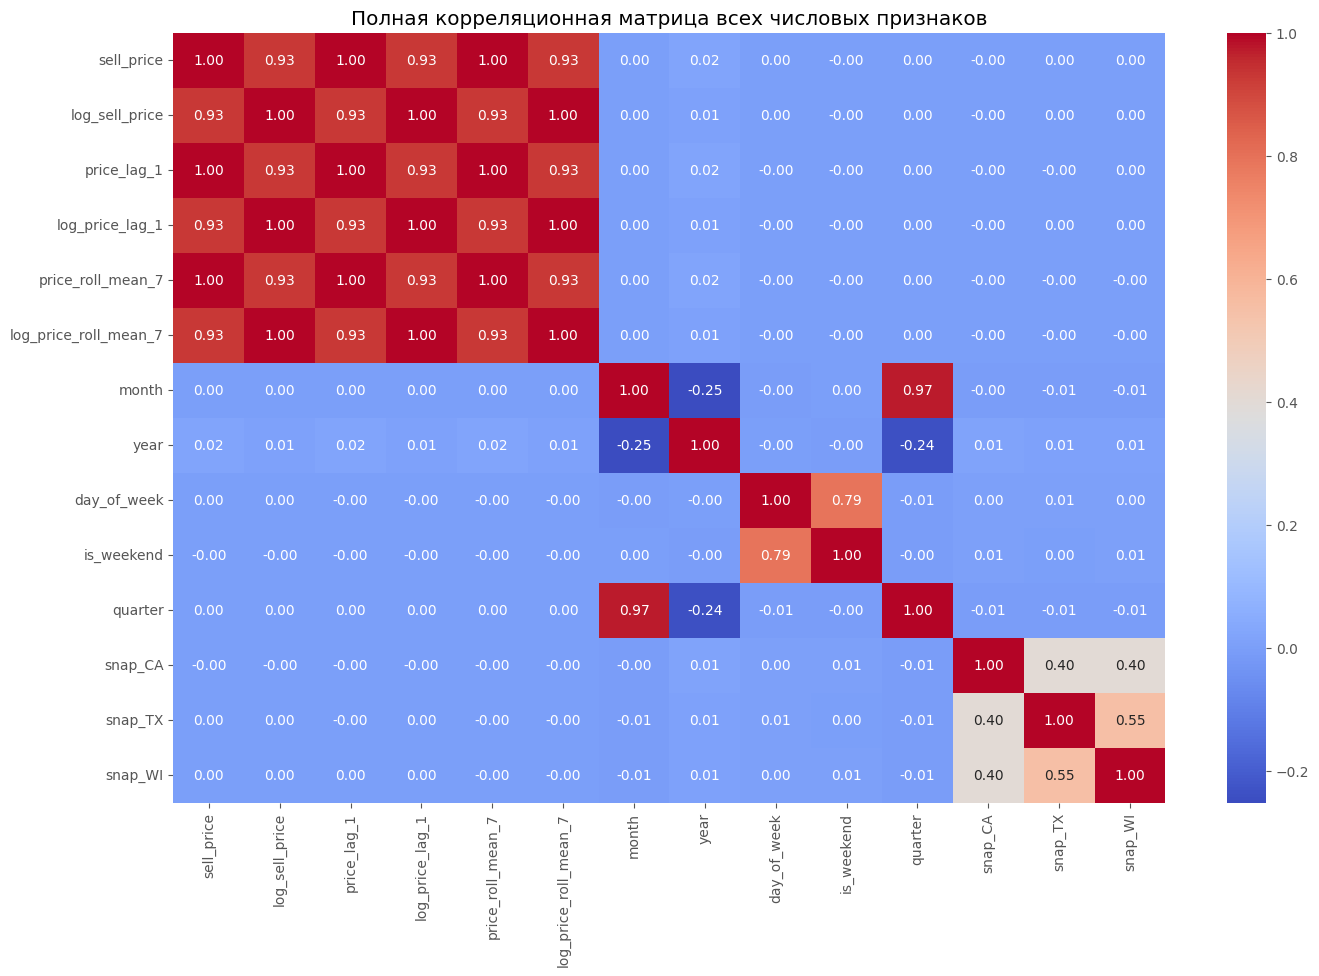

In [29]:
# Все числовые признаки, которые у нас сейчас есть в train_df
numeric_features = [
    'sell_price', 'log_sell_price',
    'price_lag_1', 'log_price_lag_1',
    'price_roll_mean_7', 'log_price_roll_mean_7',
    'month', 'year', 'day_of_week', 'is_weekend', 'quarter',
    'snap_CA', 'snap_TX', 'snap_WI'
]

# Корреляционная матрица
corr_matrix = train_df[numeric_features].corr()

# Визуализация матрицы корреляций
plt.figure(figsize=(16, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Полная корреляционная матрица всех числовых признаков')
plt.show()


In [30]:
# Удаляем признаки, потенциально содержащие утечку данных (лаги и средние по цене, а также 'quarter')
cols_to_remove = [
    'price_lag_1', 'log_price_lag_1',
    'price_roll_mean_7', 'log_price_roll_mean_7',
    'quarter'
]

train_df.drop(columns=cols_to_remove, inplace=True)
val_df.drop(columns=cols_to_remove, inplace=True)
test_df.drop(columns=cols_to_remove, inplace=True)

# Создаём бинарные признаки событий
def add_event_features(df):
    df['event_flag'] = ((df['event_name_1'] != 'NoEvent') | (df['event_name_2'] != 'NoEvent')).astype(int)

    for event_type in ['National', 'Cultural', 'Religious', 'Sporting']:
        df[f'event_type_{event_type}'] = ((df['event_type_1'] == event_type) | (df['event_type_2'] == event_type)).astype(int)

    return df

# Добавляем признаки событий
train_df = add_event_features(train_df)
val_df = add_event_features(val_df)
test_df = add_event_features(test_df)

In [31]:
# Проверка итоговых признаков
print("Итоговый набор признаков после финального обновления:")
print(train_df.columns.tolist())

Итоговый набор признаков после финального обновления:
['store_id', 'item_id', 'wm_yr_wk', 'sell_price', 'date', 'month', 'year', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI', 'day_of_week', 'is_weekend', 'log_sell_price', 'event_flag', 'event_type_National', 'event_type_Cultural', 'event_type_Religious', 'event_type_Sporting']


In [32]:
display(train_df.head(10))

,store_id,item_id,wm_yr_wk,sell_price,date,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,day_of_week,is_weekend,log_sell_price,event_flag,event_type_National,event_type_Cultural,event_type_Religious,event_type_Sporting
0,CA_1,FOODS_1_001,11101,2.00,2011-01-29,1,2011,NoEvent,NoEvent,NoEvent,NoEvent,0,0,0,5,1,1.10,0,0,0,0,0
1,CA_1,FOODS_1_001,11101,2.00,2011-01-30,1,2011,NoEvent,NoEvent,NoEvent,NoEvent,0,0,0,6,1,1.10,0,0,0,0,0
2,CA_1,FOODS_1_001,11101,2.00,2011-01-31,1,2011,NoEvent,NoEvent,NoEvent,NoEvent,0,0,0,0,0,1.10,0,0,0,0,0
3,CA_1,FOODS_1_001,11101,2.00,2011-02-01,2,2011,NoEvent,NoEvent,NoEvent,NoEvent,1,1,0,1,0,1.10,0,0,0,0,0
4,CA_1,FOODS_1_001,11101,2.00,2011-02-02,2,2011,NoEvent,NoEvent,NoEvent,NoEvent,1,0,1,2,0,1.10,0,0,0,0,0
5,CA_1,FOODS_1_001,11101,2.00,2011-02-03,2,2011,NoEvent,NoEvent,NoEvent,NoEvent,1,1,1,3,0,1.10,0,0,0,0,0
6,CA_1,FOODS_1_001,11101,2.00,2011-02-04,2,2011,NoEvent,NoEvent,NoEvent,NoEvent,1,0,0,4,0,1.10,0,0,0,0,0
7,CA_1,FOODS_1_001,11102,2.00,2011-02-05,2,2011,NoEvent,NoEvent,NoEvent,NoEvent,1,1,1,5,1,1.10,0,0,0,0,0
8,CA_1,FOODS_1_001,11102,2.00,2011-02-06,2,2011,SuperBowl,Sporting,NoEvent,NoEvent,1,1,1,6,1,1.10,1,0,0,0,1
9,CA_1,FOODS_1_001,11102,2.00,2011-02-07,2,2011,NoEvent,NoEvent,NoEvent,NoEvent,1,1,0,0,0,1.10,0,0,0,0,0


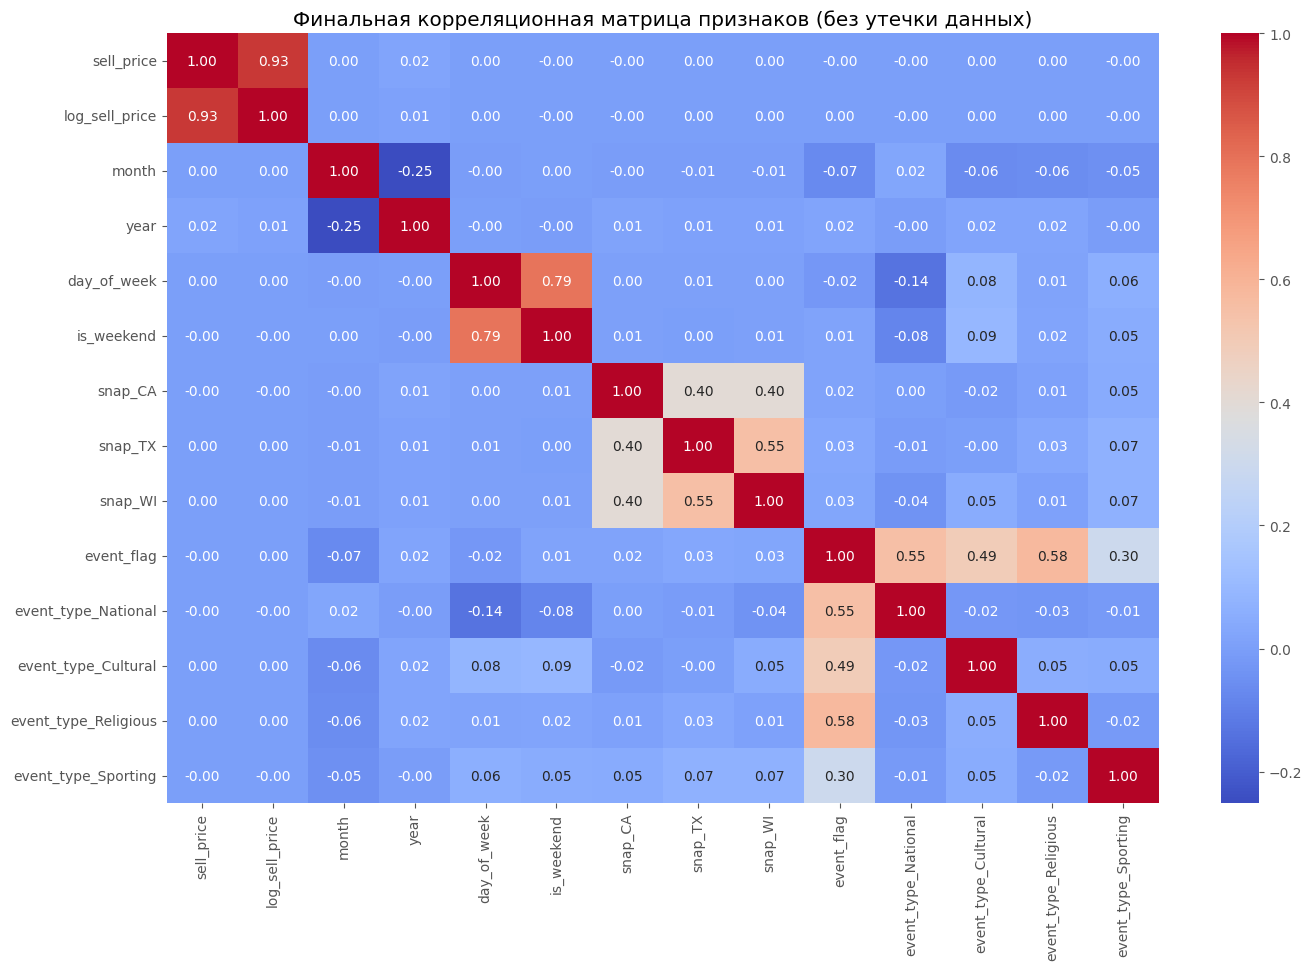

In [33]:
# Все текущие числовые признаки
numeric_features = [
    'sell_price', 'log_sell_price',
    'month', 'year', 'day_of_week', 'is_weekend',
    'snap_CA', 'snap_TX', 'snap_WI',
    'event_flag', 'event_type_National',
    'event_type_Cultural', 'event_type_Religious',
    'event_type_Sporting'
]

# Корреляционная матрица
corr_matrix = train_df[numeric_features].corr()

# Визуализация матрицы корреляций
plt.figure(figsize=(16, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Финальная корреляционная матрица признаков (без утечки данных)')
plt.show()

In [34]:
# Сохранение выборок без дополнительной стандартизации
train_df.to_parquet(PROCESSED / 'train_features_final.parquet', index=False)
val_df.to_parquet(PROCESSED / 'val_features_final.parquet', index=False)
test_df.to_parquet(PROCESSED / 'test_features_final.parquet', index=False)

print(f"Итоговые выборки успешно сохранены в папку: {PROCESSED}")

Итоговые выборки успешно сохранены в папку: /content/drive/MyDrive/price_forecasting/data/processed


In [35]:
# Вывод списка всех полей финального датасета
print("Полный список полей финального датасета:")
for col in train_df.columns:
    print("-", col)


Полный список полей финального датасета:
- store_id
- item_id
- wm_yr_wk
- sell_price
- date
- month
- year
- event_name_1
- event_type_1
- event_name_2
- event_type_2
- snap_CA
- snap_TX
- snap_WI
- day_of_week
- is_weekend
- log_sell_price
- event_flag
- event_type_National
- event_type_Cultural
- event_type_Religious
- event_type_Sporting


### Выводы:
- Проведена финальная подготовка и проверка датасета для моделирования без риска утечки информации (data leakage).
- Исключены признаки, прямо связанные с целевым признаком, которые могли привести к переобучению модели и завышенной оценке качества.
- Добавлены бинарные признаки на основе анализа календарных событий, которые помогут модели учесть влияние особых дней на изменение цен.
- Удалены признаки с высокой корреляцией и низкой информативностью (например, `quarter`), что упростило набор данных и улучшило его качество.
- Проведена детальная проверка корреляций, подтверждающая безопасность и релевантность всех итоговых признаков.
- Данные сохранены в нейтральном виде (без стандартизации и нормализации), чтобы обеспечить гибкость на этапе моделирования.
- Итоговый датасет полностью готов к следующему этапу работы — обучению моделей (Temporal Fusion Transformer и бустинг).
